<a href="https://colab.research.google.com/github/harirajeev/awesome-nlp/blob/master/fastai_ner_conll2003_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sources:

https://github.com/piegu/language-models/blob/master/lm3-portuguese-classifier-TCU-jurisprudencia.ipynb

https://colab.research.google.com/gist/davidpfahler/360606c7e6e66d78d82f7cb0e568f426/conll-fastai-v1.ipynb#scrollTo=Esp9SY33wwih

https://gist.github.com/mamamot/822944e245622e904e9bccb32633cd97

In [0]:
# !pip install fastai -q
# !curl -s https://course.fast.ai/setup/colab | bash
!pip install -U tqdm -q

     |████████████████████████████████| 61kB 3.1MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import gc
from functools import partial
from pathlib import Path
import json
from fastai.text import *
from fastai.callbacks import *
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

root_dir = Path("/content/gdrive/My Drive/")
path = root_dir/"fastai/NER/"
path.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_colwidth', 200)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.min_rows', 100)
# pd.set_option('display.max_rows', 100)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
BS=128

In [0]:
dataset_path = Path(path/"conll2003")


In [0]:
# !git clone https://github.com/patverga/torch-ner-nlp-from-scratch.git
# !mv torch-ner-nlp-from-scratch/data/conll2003 "{dataset_path}"/

In [0]:
# !rm -rf torch-ner-nlp-from-scratch

# Read data

In [0]:
df_train = pd.read_csv(dataset_path/"eng.train", sep=' ', header=None, usecols=[0,3], names=["Token", "Tag"])
df_train['valid'] = False
df_train.dropna(subset=["Token", "Tag"], inplace = True)
df_train.reset_index(drop=True, inplace=True)
df_train.head()

,Token,Tag,valid
0,-DOCSTART-,O,False
1,EU,I-ORG,False
2,rejects,O,False
3,German,I-MISC,False
4,call,O,False


In [0]:
df_valid = pd.read_csv(dataset_path/"eng.testa", sep=' ', header=None, usecols=[0,3], names=["Token", "Tag"])
df_valid['valid'] = True
df_valid.dropna(subset=["Token", "Tag"], inplace = True)
df_valid.reset_index(drop=True, inplace=True)
df_test = pd.read_csv(dataset_path/"eng.testb", sep=' ', header=None, usecols=[0,3], names=["Token", "Tag"])
df_test.dropna(subset=["Token", "Tag"], inplace = True)
df_test.reset_index(drop=True, inplace=True)
df_valid.head()

,Token,Tag,valid
0,-DOCSTART-,O,True
1,CRICKET,O,True
2,-,O,True
3,LEICESTERSHIRE,I-ORG,True
4,TAKE,O,True


In [0]:
df_test.head()

,Token,Tag
0,-DOCSTART-,O
1,SOCCER,O
2,-,O
3,JAPAN,I-LOC
4,GET,O


In [0]:
# df_train.drop(df_train[df_train.Tag.isin(["B-LOC", "B-ORG", "B-MISC"])].index, inplace=True)
# df_valid.drop(df_valid[df_valid.Tag.isin(["B-LOC", "B-ORG", "B-MISC"])].index, inplace=True)
# df_test.drop(df_test[df_test.Tag.isin(["B-LOC", "B-ORG", "B-MISC"])].index, inplace=True)

In [0]:
df_train["Token"] = df_train["Token"].str.replace("-DOCSTART-", "xxbos")
df_valid["Token"] = df_valid["Token"].str.replace("-DOCSTART-", "xxbos")
df_test["Token"] = df_test["Token"].str.replace("-DOCSTART-", "xxbos")

# Preprocess 

In [0]:
def split_to_docs(tokens, labels):
  x, y, doc, lbs = [], [], [], []
  for i, token in enumerate(tokens):
    if token == 'xxbos' and len(doc) > 0:
      x.append(doc)
      y.append(lbs)
      doc, lbs = [], []
    doc.append(token)
    lbs.append(labels[i])
  x.append(doc)
  y.append(lbs)
  return x, y

In [0]:
train_x, train_y = split_to_docs(df_train['Token'], df_train['Tag'])
valid_x, valid_y = split_to_docs(df_valid['Token'], df_valid['Tag'])
test_x, test_y = split_to_docs(df_test['Token'], df_test['Tag'])

In [0]:
train_df = pd.DataFrame({'tokens': train_x, 'labels': train_y})
train_df['set'] = 'train'
valid_df = pd.DataFrame(data = {'tokens': valid_x, 'labels': valid_y})
valid_df['set'] = 'valid'
test_df = pd.DataFrame(data = {'tokens': test_x, 'labels': test_y})
test_df['set'] = 'test'
df = pd.concat([train_df, valid_df], ignore_index=True)
df.head()

,tokens,labels,set
0,"[xxbos, EU, rejects, German, call, to, boycott, British, lamb, ., Peter, Blackburn, BRUSSELS, 1996-08-22, The, European, Commission, said, on, Thursday, it, disagreed, with, German, advice, to, co...","[O, I-ORG, O, I-MISC, O, O, O, I-MISC, O, O, I-PER, I-PER, I-LOC, O, O, I-ORG, I-ORG, O, O, O, O, O, O, I-MISC, O, O, O, O, O, I-MISC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, ...",train
1,"[xxbos, Rare, Hendrix, song, draft, sells, for, almost, $, 17,000, ., LONDON, 1996-08-22, A, rare, early, handwritten, draft, of, a, song, by, U.S., guitar, legend, Jimi, Hendrix, was, sold, for, ...","[O, O, I-PER, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O, ...",train
2,"[xxbos, China, says, Taiwan, spoils, atmosphere, for, talks, ., BEIJING, 1996-08-22, China, on, Thursday, accused, Taipei, of, spoiling, the, atmosphere, for, a, resumption, of, talks, across, the...","[O, I-LOC, O, I-LOC, O, O, O, O, O, I-LOC, O, I-LOC, O, O, O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, I-LOC, I-LOC, O, O, O, O, I-LOC, O, I-MISC, O, O, I-PER, I-PER, O, O, O, O, I-LOC, O, O, O, O,...",train
3,"[xxbos, China, says, time, right, for, Taiwan, talks, ., BEIJING, 1996-08-22, China, has, said, it, was, time, for, political, talks, with, Taiwan, and, that, the, rival, island, should, take, pra...","[O, I-LOC, O, O, O, O, I-LOC, O, O, I-LOC, O, I-LOC, O, O, O, O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-ORG, O, O, O, I-PER,...",train
4,"[xxbos, German, July, car, registrations, up, 14.2, pct, yr, /, yr, ., FRANKFURT, 1996-08-22, German, first-time, registrations, of, motor, vehicles, jumped, 14.2, percent, in, July, this, year, f...","[O, I-MISC, O, O, O, O, O, O, O, O, O, O, I-LOC, O, I-MISC, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,...",train


# Train LM

In [0]:
data_lm = (TextList.from_df(pd.concat([df, test_df], ignore_index=True), path=path, cols='tokens', processor=[num_tokens])
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch())

In [0]:
data_lm.save('data_lm')

In [0]:
data_lm = load_data(path, 'data_lm', bs=BS)

In [0]:
data_lm.show_batch()

idx,text
0,"scientific advice was xxunk . We do n't support any such recommendation because we do n't see any grounds for it , the Commission 's chief spokesman xxunk van der xxunk told a news briefing . He said further scientific study was required and if it was found that action was needed it should be taken by the European Union . He said a proposal last month by EU Farm"
1,by Iranian troops xxunk inside Iraq last month . A Mujahideen Khalq statement said its leader Massoud xxunk met in Baghdad the Secretary-General of the Kurdistan Democratic Party of Iran ( xxunk ) Hassan xxunk on Wednesday and voiced his support to Iran 's rebel Kurds . xxunk xxunk that the Iranian xxunk would continue to stand side by side with their Kurdish xxunk and the resistance movement in Iranian
2,"work and residence rights say Prime Minister Alain Juppe 's proposals are xxunk as xxunk strike enters xxunk day in Paris church and Wednesday rally xxunk 8,000 xxunk . -- xxunk xxunk nationalist movement announces end of truce after last night 's attacks . BUSINESS xxunk -- xxunk of xxunk 's French xxunk points up xxunk industry crisis , with French manufacturers xxunk by xxunk country competition and failure to"
3,"Younis xxunk , Mohammad Akram xxunk , Mushtaq Ahmed xxunk , Aamir Sohail xxunk Pakistan : Aamir Sohail , Saeed Anwar , Ijaz Ahmed , Inzamam-ul-Haq , Salim Malik , Asif Mujtaba , Wasim Akram , Moin Khan , Mushtaq Ahmed , Waqar Younis , Mohammad Akam -DOCSTART- SOCCER - xxunk xxunk IN SCOTTISH SQUAD AFTER 20 xxunk . GLASGOW 1996-08-22 Everton 's Duncan Ferguson , who scored twice against"
4,( Spain ) vs. Jordi xxunk ( Spain ) Francisco Clavet ( Spain ) vs. 16 - Cedric Pioline ( France ) ------------------------ 9 - Wayne Ferreira ( South Africa ) vs. qualifier Karol Kucera ( Slovakia ) vs. Jonas xxunk ( Sweden ) Qualifier vs. Christian xxunk ( Norway ) Alex Corretja ( Spain ) vs. Byron Black ( Zimbabwe ) David Rikl ( Czech Republic ) vs. Hicham


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5,
                               metrics=[accuracy, Perplexity()],).to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


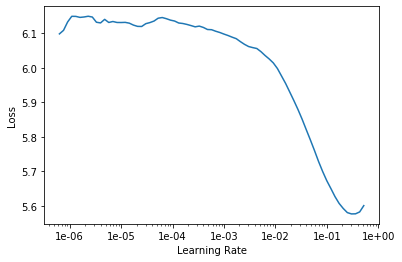

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
# learn.callback_fns = [partial(EarlyStoppingCallback, monitor="perplexity", mode="min", patience=3),
#                       partial(SaveModelCallback, monitor="perplexity", mode="min", name="best_model")]
lr = 5e-02
moms = (0.8,0.7)
wd = 0.1

In [0]:
learn.fit_one_cycle(1, slice(lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.930320,4.539720,0.251507,93.664528,00:05


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/5), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.820800,4.207790,0.278516,67.207840,00:06
1,3.566947,3.969212,0.298856,52.942799,00:06
2,3.222346,3.905181,0.309347,49.659054,00:06
3,2.875800,3.911048,0.314621,49.951279,00:06
4,2.614475,3.929655,0.314258,50.889385,00:06


In [0]:
learn.save_encoder('ft_enc')

In [0]:
torch.save(learn.model[0].encoder.state_dict(), path/'conll_lm-20_epochs_enc.pth')

In [0]:
learn.predict("A Mujahideen Khalq statement", n_words=10)

"A Mujahideen Khalq statement surgery to help reduce Albion in Europe 's foreign minister"

# NER DataBunch

In [0]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList


class NERLabelList(TextList):
    _processor = [NumericalizeProcessor]

In [0]:
num_tokens = NumericalizeProcessor()
num_labels = NumericalizeProcessor()
src = (Seq2SeqTextList.from_df(df, path=path, cols='tokens', processor=[num_tokens])
       .split_by_idx(range(len(train_df), len(train_df) + len(valid_df)))
       .label_from_df(cols='labels', label_cls=NERLabelList, processor=num_labels))

In [0]:
data = src.databunch()

In [0]:
data.save('data')

In [0]:
data = load_data(path, 'data', bs=BS)

In [0]:
data.show_batch(1)

# NER Model

In [0]:
data = load_data(path, 'data', bs=BS)

## NER LM

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [0]:
pad_idx, bos_idx = 1, 2

In [0]:
class NERRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, nout, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh, = nl,nh
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.nout = nout
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.nout)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.nout):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)   

In [0]:
xb,yb = next(iter(data.valid_dl))

In [0]:
xb.shape

torch.Size([128, 1175])

In [0]:
emb_enc = nn.Embedding(9472, 400, padding_idx=pad_idx)

In [0]:
emb_enc.load_state_dict(torch.load(path/'conll_lm-20_epochs_enc.pth'))
# emb_enc.load_state_dict(torch.load(path/'models/ft_enc.pth'));

RuntimeError: ignored

In [0]:
emb_dec = nn.Embedding(len(data.y.vocab.itos), 400, padding_idx=pad_idx)

In [0]:
rnn = NERRNN(emb_enc, emb_dec, 128, len(data.y.vocab.itos), bos_idx, pad_idx)

In [0]:
rnn

NERRNN(
  (emb_enc): Embedding(9472, 400, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(400, 128, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=128, out_features=400, bias=False)
  (emb_dec): Embedding(24, 400, padding_idx=1)
  (gru_dec): GRU(400, 400, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=400, out_features=24, bias=True)
)

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [0]:
learn.load_encoder(path/"models/ft_enc.pth")

AttributeError: ignored

# Class model

In [0]:
data_lm = load_data(path, 'data_lm', bs=BS)
data_clas = load_data(path, 'data_clas', bs=BS)

In [0]:
# data_clas = TextClasDataBunch.from_df(path, df_train, df_valid, vocab=data_lm.train_ds.vocab, bs=BS,
#                                       text_cols=["Token"],
#                                       label_cols=["Tag"],
#                                       include_bos=False)

In [0]:
data_clas.show_batch()

text,target
xxup day -- xxup company xxrep 4 - xxup period -- xxup consensus xxrep 4 - xxup range xxrep 7 - xxup xxunk,O
xxup xxunk : xxmaj xxunk - xxup xxunk,O
12 - 1 - 76 - 0,O
four - and - a - half,O
1996 - xxunk - 26,O


In [0]:
# data_clas.save("data_clas")

In [0]:
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

## Weighted Loss

In [0]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([  8286,   4556,  10001,  11128, 168343]),
 array([ 2094,  1264,  2092,  3145, 42336]))

In [0]:
trn_weights = [1 - count/len(data_clas.train_ds.y) for count in trn_LabelCounts]
val_weights = [1 - count/len(data_clas.valid_ds.y) for count in val_LabelCounts]
trn_weights, val_weights

([0.9590438625107506,
  0.9774805500360825,
  0.9505669404984332,
  0.9449963917474816,
  0.16791225520725206],
 [0.9588855510396419,
  0.9751821091280359,
  0.9589248198543127,
  0.9382497889301211,
  0.16875773104788827])

In [0]:
loss_weights = torch.FloatTensor(trn_weights).cuda()

In [0]:
# source: https://github.com/fastai/fastai/blob/master//fastai/layers.py#L300:7
# blog: https://bfarzin.github.io/Label-Smoothing/
class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, f1]).to_fp16(clip=0.1)
learn.load_encoder('ft_enc');
learn.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [0]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8136, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8136, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


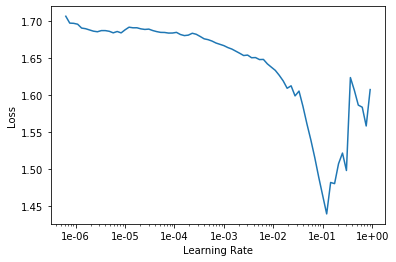

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [0]:
lr = 5e-02
moms = (0.8,0.7)
wd = 0.1

In [0]:
learn.fit_one_cycle(1, slice(lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.052803,0.702191,0.880073,0.871107,00:26


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(lr/2/(2.6**4),lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.012140,0.837703,0.831871,0.797422,00:30
1,0.837523,0.869586,0.834462,0.802615,00:29


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(lr/2/(2.6**4),lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.948432,1.260719,0.843553,0.831475,00:34
1,0.852915,0.900489,0.890852,0.882369,00:34


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/5/(2.6**4),lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.850330,0.911130,0.889969,0.881296,00:41
1,0.813723,0.691661,0.891736,0.883300,00:42


In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3]+cm[4,4])/(cm.sum())}')

# acc neg, acc pos
print(f'I-LOC accuracy: {cm[0,0]/(cm.sum(1)[0])*100}') 
print(f'I-MISC accuracy: {cm[1,1]/(cm.sum(1)[1])*100}')
print(f'I-ORG accuracy: {cm[2,2]/(cm.sum(1)[2])*100}')
print(f'I-PER accuracy: {cm[3,3]/(cm.sum(1)[3])*100}')
print(f'O accuracy: {cm[4,4]/(cm.sum(1)[4])*100}')

[[  174    13   485  1403    19]
 [   19   280   134   746    85]
 [   46    18   736  1147   145]
 [    2     4   123  2941    75]
 [    6    81   245   718 41286]]
accuracy global: 0.891735877952524
I-LOC accuracy: 8.30945558739255
I-MISC accuracy: 22.151898734177212
I-ORG accuracy: 35.18164435946463
I-PER accuracy: 93.51351351351352
O accuracy: 97.51984126984127


In [0]:
learn.predict("United")

(Category I-LOC,
 tensor(0),
 tensor([ 2.3730, -1.1455,  1.0000, -4.0117, -0.1790]))

# Decoder

In [0]:
data = load_data(path, 'data', bs=BS)
# data.show_batch(1)

In [0]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8136, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8136, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): LinearDecoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (hidden_to_tag): Linear(in_features=1152, out_features=24, bias=True)
    (activation): LogSoftmax()
    (loss_f): NLLLoss()
  )
)

In [0]:
def get_ner(arch:Callable, vocab_sz:int, n_tags:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1, weights:Collection[float]=None) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    meta = _model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    config.pop('output_p')
    init = config.pop('init') if 'init' in config else None
    encoder = MultiBatchEncoder(bptt, max_len, arch(vocab_sz, **config), pad_idx=pad_idx)
    model = SequentialRNN(encoder, LinearDecoder(output_size=n_tags,
                                                 n_hid=config["n_hid"], weights=loss_weights))
    return model if init is None else model.apply(init)

def ner_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=70*20, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, weights:Collection[float]=None, **learn_kwargs) -> 'NerLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_ner(arch, len(data.vocab.itos), len(data.y.vocab.itos), bptt=bptt, max_len=max_len,
                              config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps,
                              weights=weights)
    meta = _model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

In [0]:
from fastai.text.learner import _model_meta

class LinearDecoder(nn.Module):
    def __init__(self, output_size, n_hid, dropout_p=0.1, weights=None):
        """
        :param output_size: number of tags
        :param n_hid: encoder output dimensions
        :param dropout: dropout to apply to *raw* encoder outputs
        :param weights: loss weights to deal with class imbalance
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_to_tag = nn.Linear(n_hid, output_size)
        self.activation = nn.LogSoftmax(dim=2)
        self.loss_f = nn.NLLLoss(reduction="none", weight=weights)
        
    def forward(self, input):
        """
        Returns predictions and loss
        
        Parameter `mask` is used to mask out tokens such as punctuation or xxbos
        :param input_seq: a batch of sentences of same size
        :param output_seq: a batch of tag sequences
        :param mask: 1 for words that you need to provide tags to
        """
        input_seq, output_seq, mask = input

        # encoded_states = self.dropout(self.encoder(input_seq)[0][2])
        encoded_states = self.dropout(input_seq[0][2])
        display(self.hidden_to_tag(encoded_states).shape)
        predictions = self.activation(self.hidden_to_tag(encoded_states))
        losses = list()
        for i, (pred, active, out) in enumerate(zip(predictions, mask, output_seq)):
            loss = self.loss_f(pred, out) * active
            losses.append(torch.sum(loss))
        losses = torch.stack(losses)
        total_loss = torch.sum(losses)

        return predictions, total_loss
  

In [0]:
learn = ner_learner(data, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, f1]).to_fp16()
learn.load_encoder('ft_enc');
# learn.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1,time


torch.Size([1336, 24])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: ignored

In [0]:
# learn.lr_find()
# learn.recorder.plot(skip_end=10)

In [0]:
|lr = 5e-02
moms = (0.8,0.7)
wd = 0.1